# Module 2: Model Metrics Analysis

## Hands-On Lab: Analyzing Model Performance Over Time

### Overview

In this notebook, you'll analyze **all model metrics collected** during the monitoring pipeline execution. You'll examine:

- **Accuracy trends** over multiple time periods
- **Precision, Recall, and F1 scores** across periods
- **Degradation patterns** and detection
- **Expected vs. actual accuracy** comparison
- **Statistical analysis** of model performance

This is the **final piece** of the monitoring workflow, where you synthesize insights from:
- Script 02: `02_prepare_artificial_data.py` (creates ground truth with degradation)
- Script 03: `03_monitoring_pipeline.py` (collects metrics across periods)


## Learning Goals

By the end of this notebook, you'll:

1. ✅ **Load and parse** monitoring results from JSON files
2. ✅ **Visualize** accuracy degradation patterns
3. ✅ **Identify** when and where model degradation is detected
4. ✅ **Compare** actual vs. expected accuracy by period
5. ✅ **Analyze** precision-recall tradeoffs
6. ✅ **Understand** the complete monitoring pipeline flow
7. ✅ **Interpret** degradation thresholds and their impact


## Section 1: Setup and Data Loading

### Step 1.1: Import Libraries


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set up visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print('✓ Libraries imported successfully')


✓ Libraries imported successfully


### Step 1.2: Load Monitoring Results

The `monitoring_results.json` file contains comprehensive metrics collected from the monitoring pipeline.


In [2]:
# Define data paths
DATA_DIR = Path('../data')  # Relative to module2/

monitoring_results_path = DATA_DIR / 'monitoring_results.json'
metadata_path = DATA_DIR / 'ground_truth_metadata.json'

# Check if files exist
if not monitoring_results_path.exists():
    print(f'❌ Error: {monitoring_results_path} not found')
    print(f'   Make sure you have run the monitoring pipeline first')
else:
    print(f'✓ Found monitoring results at: {monitoring_results_path}')

if not metadata_path.exists():
    print(f'❌ Error: {metadata_path} not found')
else:
    print(f'✓ Found metadata at: {metadata_path}')


✓ Found monitoring results at: ../data/monitoring_results.json
✓ Found metadata at: ../data/ground_truth_metadata.json


In [3]:
# Load monitoring results
with open(monitoring_results_path, 'r') as f:
    monitoring_results = json.load(f)

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print('\n' + '='*80)
print('MONITORING PIPELINE SUMMARY')
print('='*80)
print(f'\nStatus: {monitoring_results["status"].upper()}')
print(f'Periods Processed: {monitoring_results["num_periods_processed"]}')
print(f'\nMetadata:')
print(f'  Total Samples: {metadata["total_samples"]}')
print(f'  Total Periods: {metadata["num_periods"]}')
print(f'  Samples per Period: {metadata["samples_per_period"]}')



MONITORING PIPELINE SUMMARY

Status: DEGRADATION_DETECTED
Periods Processed: 2

Metadata:
  Total Samples: 1000
  Total Periods: 4
  Samples per Period: 250


## Section 2: Overview of Collected Metrics


In [4]:
# Extract period data into a DataFrame
periods_data = []

for period_result in monitoring_results['periods']:
    period_dict = {
        'period': period_result['period'],
        'num_samples': period_result['num_samples'],
        'accuracy': period_result['metrics']['accuracy'],
        'precision': period_result['metrics']['precision'],
        'recall': period_result['metrics']['recall'],
        'f1': period_result['metrics']['f1'],
        'previous_accuracy': period_result['previous_accuracy'],
        'accuracy_drop': period_result['accuracy_drop'],
        'is_degraded': period_result['is_degraded']
    }
    periods_data.append(period_dict)

df_periods = pd.DataFrame(periods_data)

print('\n' + '='*80)
print('PERIOD METRICS SUMMARY')
print('='*80)
print()
print(df_periods.to_string(index=False))



PERIOD METRICS SUMMARY

 period  num_samples  accuracy  precision   recall       f1  previous_accuracy  accuracy_drop  is_degraded
      0          250     0.936   0.892308 0.865672 0.878788                NaN            NaN        False
      1          250     0.820   0.745098 0.542857 0.628099              0.936          0.116         True


## Section 3: Accuracy Visualization


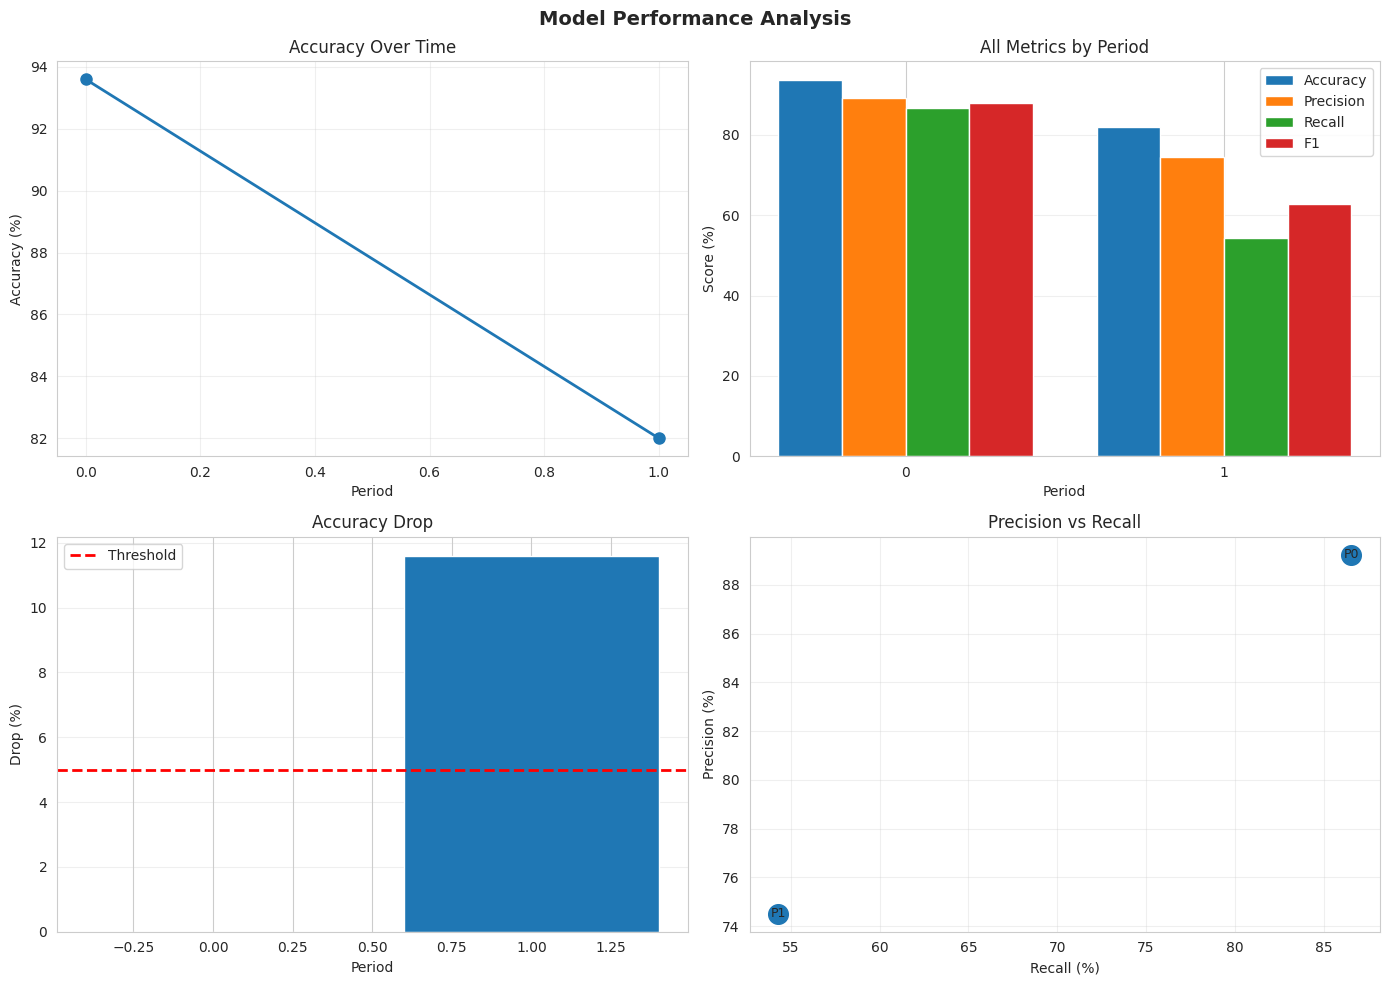


Visualizations created successfully


In [5]:
# Visualize accuracy trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Analysis', fontsize=14, fontweight='bold')

# Accuracy trend
ax1 = axes[0, 0]
ax1.plot(df_periods['period'], df_periods['accuracy']*100, 
         marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Period')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Over Time')
ax1.grid(True, alpha=0.3)

# Metrics comparison
ax2 = axes[0, 1]
x = np.arange(len(df_periods))
width = 0.2
ax2.bar(x - 1.5*width, df_periods['accuracy']*100, width, label='Accuracy')
ax2.bar(x - 0.5*width, df_periods['precision']*100, width, label='Precision')
ax2.bar(x + 0.5*width, df_periods['recall']*100, width, label='Recall')
ax2.bar(x + 1.5*width, df_periods['f1']*100, width, label='F1')
ax2.set_xlabel('Period')
ax2.set_ylabel('Score (%)')
ax2.set_title('All Metrics by Period')
ax2.set_xticks(x)
ax2.set_xticklabels(df_periods['period'].astype(int))
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Accuracy drops
ax3 = axes[1, 0]
drops = df_periods['accuracy_drop'].fillna(0)*100
ax3.bar(df_periods['period'], drops)
ax3.axhline(y=monitoring_results['configuration']['degradation_threshold']*100, 
             color='red', linestyle='--', linewidth=2, label='Threshold')
ax3.set_xlabel('Period')
ax3.set_ylabel('Drop (%)')
ax3.set_title('Accuracy Drop')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Precision vs Recall
ax4 = axes[1, 1]
ax4.scatter(df_periods['recall']*100, df_periods['precision']*100, s=200)
for _, row in df_periods.iterrows():
    ax4.annotate(f"P{int(row['period'])}", 
                xy=(row['recall']*100, row['precision']*100),
                fontsize=9, ha='center', va='center')
ax4.set_xlabel('Recall (%)')
ax4.set_ylabel('Precision (%)')
ax4.set_title('Precision vs Recall')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nVisualizations created successfully')


## Section 4: Detailed Metrics Analysis


In [6]:
print('\n' + '='*80)
print('DETAILED PERIOD ANALYSIS')
print('='*80)

config = monitoring_results['configuration']

for _, row in df_periods.iterrows():
    period = int(row['period'])
    print(f'\nPeriod {period}:')
    print(f'  Samples: {row["num_samples"]}')
    print(f'  Accuracy: {row["accuracy"]*100:.2f}%')
    print(f'  Precision: {row["precision"]*100:.2f}%')
    print(f'  Recall: {row["recall"]*100:.2f}%')
    print(f'  F1 Score: {row["f1"]*100:.2f}%')
    
    if pd.notna(row['accuracy_drop']):
        print(f'  Accuracy Drop: {row["accuracy_drop"]*100:.2f}%')
        print(f'  Degraded: {"Yes" if row["is_degraded"] else "No"}')


DETAILED PERIOD ANALYSIS

Period 0:
  Samples: 250
  Accuracy: 93.60%
  Precision: 89.23%
  Recall: 86.57%
  F1 Score: 87.88%

Period 1:
  Samples: 250
  Accuracy: 82.00%
  Precision: 74.51%
  Recall: 54.29%
  F1 Score: 62.81%
  Accuracy Drop: 11.60%
  Degraded: Yes


## Section 5: Summary Statistics


In [7]:
print('\n' + '='*80)
print('SUMMARY STATISTICS')
print('='*80)

print(f'\nAccuracy:')
print(f'  Mean: {df_periods["accuracy"].mean()*100:.2f}%')
print(f'  Min: {df_periods["accuracy"].min()*100:.2f}%')
print(f'  Max: {df_periods["accuracy"].max()*100:.2f}%')

print(f'\nPrecision:')
print(f'  Mean: {df_periods["precision"].mean()*100:.2f}%')

print(f'\nRecall:')
print(f'  Mean: {df_periods["recall"].mean()*100:.2f}%')

print(f'\nF1 Score:')
print(f'  Mean: {df_periods["f1"].mean()*100:.2f}%')

num_degraded = df_periods['is_degraded'].sum()
print(f'\nDegradation Events: {num_degraded}')



SUMMARY STATISTICS

Accuracy:
  Mean: 87.80%
  Min: 82.00%
  Max: 93.60%

Precision:
  Mean: 81.87%

Recall:
  Mean: 70.43%

F1 Score:
  Mean: 75.34%

Degradation Events: 1


## Section 6: Conclusions

You have successfully completed the Model Metrics Analysis notebook!

### Key Takeaways:

1. **Model monitoring requires continuous tracking** of performance metrics across time
2. **Multiple metrics matter**: Accuracy alone doesn't tell the complete story
3. **Thresholds are critical**: Both absolute minimum and degradation rate detection
4. **Automation enables scale**: The CML job framework runs the entire monitoring pipeline automatically
5. **Degradation detection is actionable**: Systems can respond automatically to model drift

### Next Steps:

- Explore different threshold values for your use case
- Consider additional metrics (AUC, ROC curves, confusion matrices)
- Implement automated retraining when degradation is detected
- Extend monitoring to production model deployments
